Building on our initial exploration, we be more quantitative and try to reproduce something like Fig. 2a in the paper, or at least a portion of it subject to the annealing times we can access. We copy the necessary imports and function definitions:

In [1]:
from dwave.system import EmbeddingComposite, DWaveSampler
import networkx as nx # For drawing graphs
import matplotlib.pyplot as plt
import numpy as np

def anneal_1d_chain(J_val, N, ta, n_reads):
    # Construct dictionaries for qubit biases and couplers:
    h = {} # No biases needed
    J = {} # Coupler dictionary
    for i in range(N):
        key_tuple = ('s{}'.format(i), 's{}'.format((i + 1) % N))
        J[key_tuple] = J_val
    sampler = EmbeddingComposite(DWaveSampler()) # Sampler to use, with auto-embedding
    samples = sampler.sample_ising(h, J, num_reads=n_reads, label='Anneal a small spin chain as a test', annealing_time=ta) # Do a single anneal

    return samples

def draw_chain(N, spins):
    plt.figure()
    G = nx.Graph()
    G.add_nodes_from(range(N), spin=spins) # Add spins to graph
    for i in range(N):
        G.add_edge(i, (i + 1) % N)

    nx.draw_circular(G, cmap=plt.get_cmap('bwr'), node_color=spins, node_size=100)

Now we vary the annealing time for a fixed chain length and coupling strength:

In [2]:
import csv

ta = np.logspace(0, 3) #np.linspace(0.5, 2000, 10) # Annealing times in us
J = 1
N = 512
n_reads = 100

def calc_kink_density(sample):
    kink_count = len([x for x in range(1, len(sample)) if sample[x] != sample[x - 1]]) 
    kink_density = kink_count/len(sample)
    return kink_density

average_kink_densities = []
for time in ta:
    samples = anneal_1d_chain(J, N, time, n_reads)
    average_kink_density = 0
    n = 0
    for rec in samples.record:
        average_kink_density += rec[2]*calc_kink_density(rec[0])
        n += rec[2]
    average_kink_densities.append(average_kink_density/n)

np.savetxt('ta.csv', ta, delimiter=',')
np.savetxt('average_kink_densities.csv', average_kink_densities, delimiter=',')
params = {'J':J, 'N': N, 'n_reads': n_reads}

w = csv.writer(open("params.csv", "w"))

for key, val in params.items():
    w.writerow([key, val])

Text(0, 0.5, 'Average kink density')

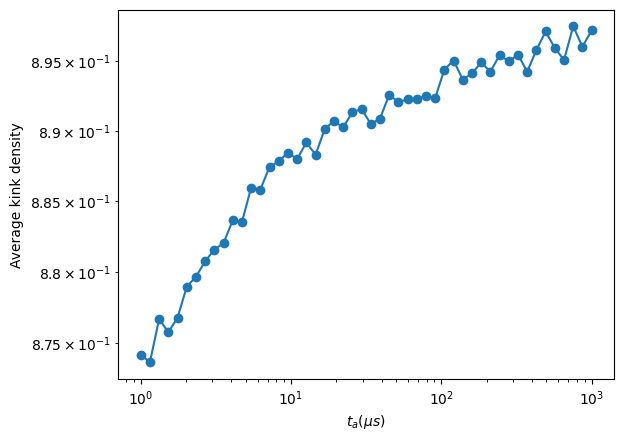

In [6]:
plt.plot(ta, average_kink_densities, '-o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_a (\mu s)$')
plt.ylabel('Average kink density')